Классы: ['Гароу', 'Генос', 'Сайтама', 'Соник', 'Татсумаки', 'Фубуки']
Размер обучающего набора: 180
Размер тестового набора: 600


d:\DL+AI\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\DL+AI\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Инициализирована модель: resnet18

Epoch 1/5
----------


train: 100%|██████████| 6/6 [00:23<00:00,  3.88s/it, loss=2.3566, acc=0.5917]


train Loss: 1.5711 Acc: 0.3944


test: 100%|██████████| 19/19 [00:25<00:00,  1.32s/it, loss=4.4252, acc=0.6513]


test Loss: 3.3632 Acc: 0.4950


Epoch 2/5
----------


train: 100%|██████████| 6/6 [00:21<00:00,  3.55s/it, loss=1.6246, acc=0.9250]


train Loss: 1.0830 Acc: 0.6167


test: 100%|██████████| 19/19 [00:25<00:00,  1.32s/it, loss=2.4342, acc=0.6996]


test Loss: 1.8500 Acc: 0.5317


Epoch 3/5
----------


train: 100%|██████████| 6/6 [00:21<00:00,  3.63s/it, loss=1.4215, acc=1.0417]


train Loss: 0.9477 Acc: 0.6944


test: 100%|██████████| 19/19 [00:25<00:00,  1.36s/it, loss=4.4661, acc=0.8860]


test Loss: 3.3942 Acc: 0.6733


Epoch 4/5
----------


train: 100%|██████████| 6/6 [00:22<00:00,  3.67s/it, loss=1.3068, acc=1.0833]


train Loss: 0.8712 Acc: 0.7222


test: 100%|██████████| 19/19 [00:24<00:00,  1.30s/it, loss=8.2111, acc=0.7105]


test Loss: 6.2404 Acc: 0.5400


Epoch 5/5
----------


train: 100%|██████████| 6/6 [00:22<00:00,  3.69s/it, loss=1.2056, acc=1.0833]


train Loss: 0.8037 Acc: 0.7222


test: 100%|██████████| 19/19 [00:24<00:00,  1.27s/it, loss=3.3575, acc=0.7829]


test Loss: 2.5517 Acc: 0.5950

Обучение завершено за 3m 56s
Лучшая точность на тестовом наборе: 0.6733


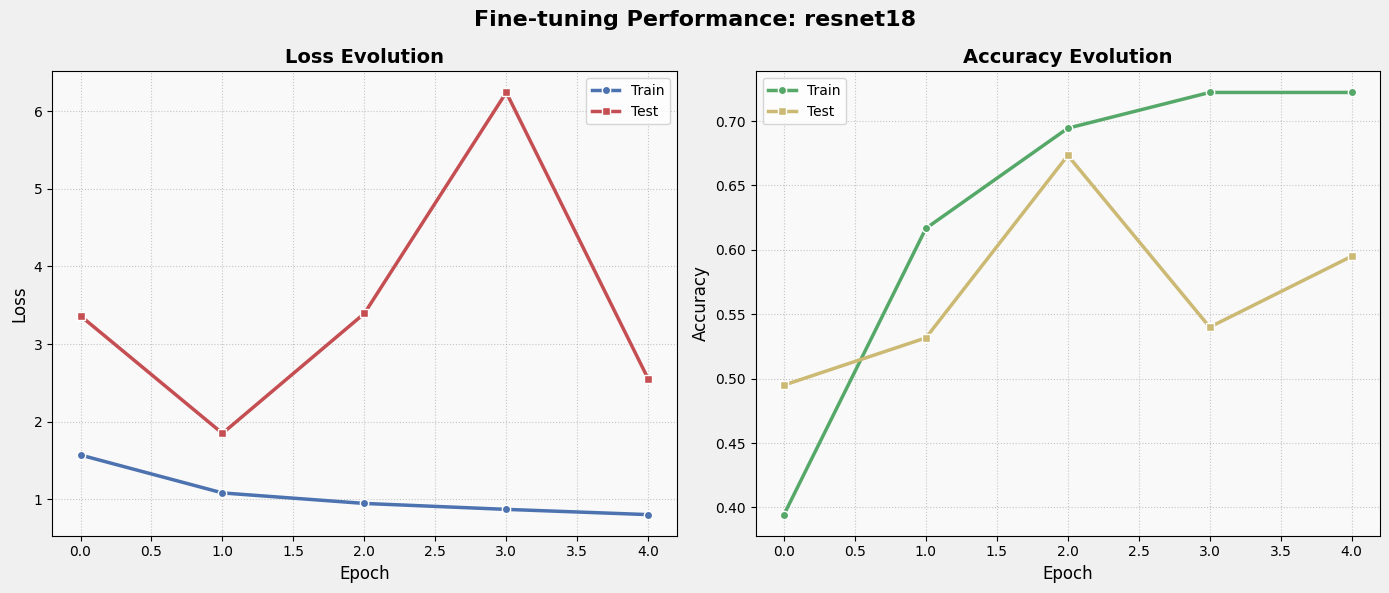

Evaluation: 100%|██████████| 19/19 [00:23<00:00,  1.24s/it]



Classification Report on Test Set:
              precision    recall  f1-score   support

       Гароу     0.4889    0.8800    0.6286       100
       Генос     1.0000    0.1300    0.2301       100
     Сайтама     0.6538    0.8500    0.7391       100
       Соник     0.7170    0.7600    0.7379       100
   Татсумаки     0.8958    0.8600    0.8776       100
      Фубуки     0.7467    0.5600    0.6400       100

    accuracy                         0.6733       600
   macro avg     0.7504    0.6733    0.6422       600
weighted avg     0.7504    0.6733    0.6422       600



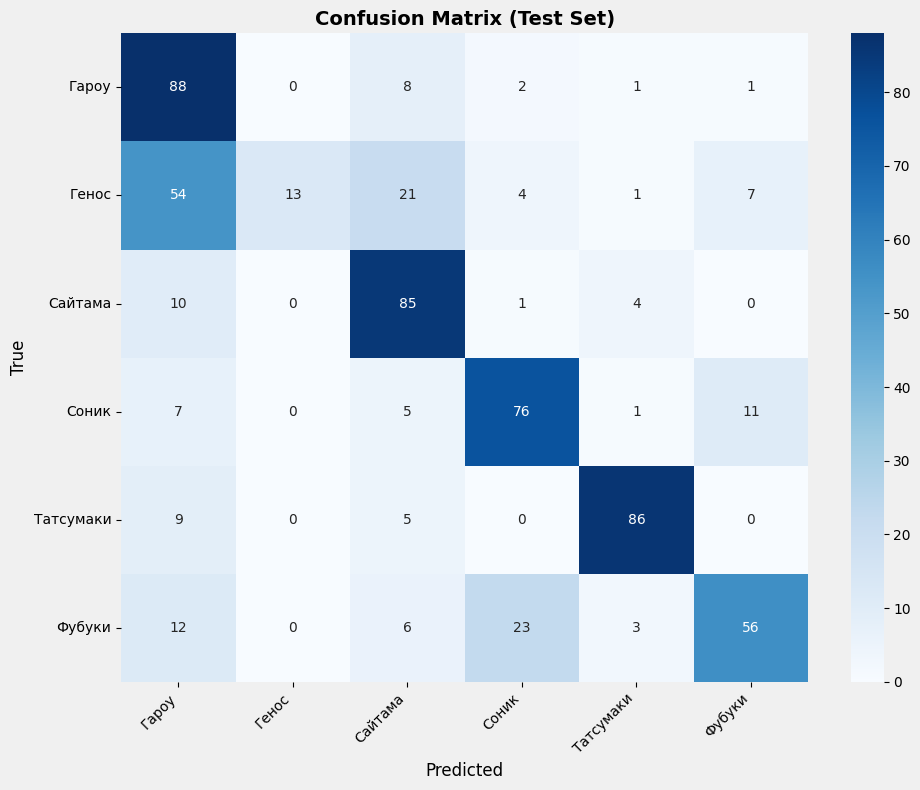


Model saved as resnet18_fine_tuned.pth


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tqdm import tqdm
import numpy as np

# Конфигурация эксперимента
MODEL_NAME = "resnet18"
NUM_EPOCHS = 5
BATCH_SIZE = 32
LEARNING_RATE = 0.001
DATA_DIR = "data"  # Папка должна содержать подпапки train и test

# Цветовая схема для графиков
COLORS = {
    'train_loss': '#4c72b0',    # Синий
    'test_loss': '#c44e52',     # Красный
    'train_acc': '#55a868',     # Зеленый
    'test_acc': '#ccb974'       # Золотистый
}

# Аугментации для обучающих данных
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Загрузка данных
image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(DATA_DIR, x),
        data_transforms[x]
    )
    for x in ['train', 'test']  # Используем test вместо val
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x],
        batch_size=BATCH_SIZE,
        shuffle=True if x == 'train' else False,
        num_workers=4
    )
    for x in ['train', 'test']  # Используем test вместо val
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes
num_classes = len(class_names)

print(f"Классы: {class_names}")
print(f"Размер обучающего набора: {dataset_sizes['train']}")
print(f"Размер тестового набора: {dataset_sizes['test']}")

# Инициализация модели
def initialize_model(model_name, num_classes):
    """Инициализирует предобученную модель"""
    model = None
    
    if model_name == "resnet18":
        model = models.resnet18(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    else:
        raise ValueError(f"Модель {model_name} не поддерживается")
    
    return model

model = initialize_model(MODEL_NAME, num_classes)
print(f"\nИнициализирована модель: {MODEL_NAME}")

# Настройка обучения
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Функция для обучения модели
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    """Обучает модель и возвращает лучшие веса"""
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # Для хранения истории обучения
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],  # Изменилось с val на test
        'test_acc': []    # Изменилось с val на test
    }
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print('-' * 10)
        
        # Каждая эпоха имеет фазы обучения и тестирования
        for phase in ['train', 'test']:  # Используем test вместо val
            if phase == 'train':
                model.train()  # Режим обучения
            else:
                model.eval()   # Режим оценки
            
            running_loss = 0.0
            running_corrects = 0
            
            # Прогресс-бар
            pbar = tqdm(dataloaders[phase], desc=phase)
            
            # Итерация по данным
            for inputs, labels in pbar:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Обнуляем градиенты
                optimizer.zero_grad()
                
                # Прямой проход
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Обратный проход + оптимизация только в фазе обучения
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Статистика
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                # Обновляем прогресс-бар
                epoch_loss = running_loss / ((pbar.n + 1) * inputs.size(0))
                epoch_acc = running_corrects.double() / ((pbar.n + 1) * inputs.size(0))
                pbar.set_postfix({
                    'loss': f'{epoch_loss:.4f}',
                    'acc': f'{epoch_acc:.4f}'
                })
            
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            # Сохраняем историю
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Сохраняем лучшую модель
            if phase == 'test' and epoch_acc > best_acc:  # Используем test вместо val
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
    
    time_elapsed = time.time() - since
    print(f'Обучение завершено за {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Лучшая точность на тестовом наборе: {best_acc:.4f}')
    
    # Загружаем лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model, history

# Обучаем модель
model, history = train_model(
    model, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS
)

# Визуализация процесса обучения с новой цветовой схемой
def plot_training_history(history):
    """Визуализирует историю обучения с улучшенным дизайном"""
    plt.figure(figsize=(14, 6), facecolor='#f0f0f0')
    
    # График функции потерь
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], 
             label='Train', 
             color=COLORS['train_loss'], 
             linewidth=2.5,
             marker='o',
             markersize=6,
             markeredgecolor='white')
    
    plt.plot(history['test_loss'], 
             label='Test', 
             color=COLORS['test_loss'], 
             linewidth=2.5,
             marker='s',
             markersize=6,
             markeredgecolor='white')
    
    plt.title('Loss Evolution', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(frameon=True, facecolor='white', edgecolor='#cccccc')
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.gca().set_facecolor('#f9f9f9')
    
    # График точности
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], 
             label='Train', 
             color=COLORS['train_acc'], 
             linewidth=2.5,
             marker='o',
             markersize=6,
             markeredgecolor='white')
    
    plt.plot(history['test_acc'], 
             label='Test', 
             color=COLORS['test_acc'], 
             linewidth=2.5,
             marker='s',
             markersize=6,
             markeredgecolor='white')
    
    plt.title('Accuracy Evolution', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(frameon=True, facecolor='white', edgecolor='#cccccc')
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.gca().set_facecolor('#f9f9f9')
    
    plt.suptitle(f'Fine-tuning Performance: {MODEL_NAME}', 
                 fontsize=16, 
                 fontweight='bold',
                 y=0.98)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=150, facecolor='#f0f0f0')
    plt.show()

plot_training_history(history)

# Оценка модели на тестовом наборе
def evaluate_model(model):
    """Оценивает модель на тестовом наборе"""
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloaders['test'], desc='Evaluation'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    print("\nClassification Report on Test Set:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
    
    # Матрица ошибок (дополнительно)
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8), facecolor='#f0f0f0')
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.title('Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=150, facecolor='#f0f0f0')
    plt.show()

evaluate_model(model)

# Сохранение модели
torch.save(model.state_dict(), f'{MODEL_NAME}_fine_tuned.pth')
print(f"\nModel saved as {MODEL_NAME}_fine_tuned.pth")